# Rotten Fruit Classification Using CNN
References:
<br>
1. https://www.tensorflow.org/tutorials/images/cnn
2. https://www.kaggle.com/code/vencerlanz09/animal-image-classification-using-efficientnetb7/notebook#%F0%9F%A4%B9Training-the-model
3. https://github.com/mrdbourke/tensorflow-deep-learning
<br>


### Importing Libraries and Paths

In [1]:
# To download the helper functions python file (Run it once if local device)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-10 13:53:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.6'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-10 13:53:17 (52.5 MB/s) - 'helper_functions.py.6' saved [10246/10246]



In [1]:
import cv2	
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import seaborn as sns

# Tensorflow import
from tensorflow.keras import layers, models, losses, optimizers, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import series of helper functions for our notebook
from helper_functions import walk_through_dir, make_confusion_matrix

# Creating reports and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
dataset = "./Resized_Dataset"
train_dataset = "./Resized_Dataset/train"
test_dataset = "./Resized_Dataset/test"

In [3]:
walk_through_dir(dataset)

There are 2 directories and 0 images in './Resized_Dataset'.
There are 2 directories and 0 images in './Resized_Dataset\test'.
There are 0 directories and 488 images in './Resized_Dataset\test\Apple_Healthy'.
There are 0 directories and 585 images in './Resized_Dataset\test\Apple_Rotten'.
There are 2 directories and 0 images in './Resized_Dataset\train'.
There are 0 directories and 1950 images in './Resized_Dataset\train\Apple_Healthy'.
There are 0 directories and 2339 images in './Resized_Dataset\train\Apple_Rotten'.


In [4]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

# Verify that all image files are uncorrupted
path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

path = Path(dataset).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

path = Path(dataset).rglob("*.jpeg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

### Load Images into DataFrame
<br>
Load the image paths and the classes into Pandas DataFrame. 
<br>
<br>
The images are classified into Folders and no text files. Walk through the dataset path and classify it. If the current location is at "Apple_Healthy" set the class as "Healthy". If the current location is at "train" append to the list of training rows.
<br>
<br>
There are only 2 classes in this dataset. "Healthy" and "Rotten"

In [5]:
train_dicts = []
test_dicts = []

# Read Folder for Data Images and appending to DataFrame
for dirname, _, filenames in os.walk(dataset):
	for filename in filenames:
		row_data = {}
		file_path = os.path.join(dirname, filename)
		
		# Compute each row's data
		row_data["id"] = os.path.splitext(filename)[0]

		row_data["path"] = os.path.join(dirname, filename)
		if (dirname.find("Apple_Healthy") > 0):
			row_data["label"] = "Healthy"
		if (dirname.find("Apple_Rotten") > 0):
			row_data["label"] = "Rotten"

		# Add into separate data frames depending on which dir is it from
		if (dirname.find("train") > 0):
			train_dicts.append(row_data)
		else:
			test_dicts.append(row_data)
		

# Create DataFrame
train_df = pd.DataFrame(train_dicts)
test_df = pd.DataFrame(test_dicts)

# View number of training and testing images
print(len(train_df.index))
print(len(test_df.index))
train_df.head()

4289
1073


,id,path,label
0,FreshApple (1),./Resized_Dataset\train\Apple_Healthy\FreshApp...,Healthy
1,freshApple (1),./Resized_Dataset\train\Apple_Healthy\freshApp...,Healthy
2,FreshApple (10),./Resized_Dataset\train\Apple_Healthy\FreshApp...,Healthy
3,FreshApple (100),./Resized_Dataset\train\Apple_Healthy\FreshApp...,Healthy
4,FreshApple (101),./Resized_Dataset\train\Apple_Healthy\FreshApp...,Healthy


In [6]:
# Show unique classes
train_df["label"].unique()

array(['Healthy', 'Rotten'], dtype=object)

### Setting up for Model Training
<br>
First, load the data into Tensorflow tensors. To do this we use ImageDataGenerator to assist us. Then we flow from dataframe. We first have to define a couple of parameters and settings. Then, we import the necessary class and pass the data from the dataframe into the generator.
<br>
<br>
Next, we will define the model for training. This includes the layers for the model, the optimizer function, the loss function, and others. After defining the model, we will compile it together. The model will then be ready for training.

In [7]:
# Define Hyperparameters
epochs = 10
batch_size = 32     
image_size = (224,224)

In [8]:
# To convert Dataframe into Tensorflow Datasets
train_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

test_generator = ImageDataGenerator(
    rescale=1./255
)

In [9]:
# Split dataset into train, validate, test sets
# Ratio is: 60:20:20%
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

Found 3432 validated image filenames belonging to 2 classes.
Found 857 validated image filenames belonging to 2 classes.
Found 1073 validated image filenames belonging to 2 classes.


In [10]:
# Validate that images are loaded
iterations = 0
for image_batch, labels_batch in train_images:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


print(len(train_images))

(32, 224, 224, 3)
(32,)
108


In [11]:
# Define the model
model = models.Sequential()
# Add the Convolutional Layers and max pooling
# Input shape is based on image size and channel
# Activation function of ReLu
model.add(layers.Input(shape=(224,224,3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
# After computing the filter, need to feed it into a Dense layer for classification
# However, the current output is a 3D, need to flatten
model.add(layers.Flatten())
# Classification
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.33))
# Only 2 output class ("Healthy", "Rotten")
model.add(layers.Dense(1, activation='sigmoid'))



In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,713 (45.64 MB)

 Trainable params: 11,963,585 (45.64 MB)

 Non-trainable params: 128 (512.00 B)

In [13]:
# Define optimizers and loss functions
optimizer = optimizers.Adam(learning_rate = 0.0001)
loss_func = losses.BinaryCrossentropy()

# Compile the model.        
model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])


### Model Training
<br>
The model will be fitted based on the datasets provided. There will be also extra callback functions for convenience purposes. Early stopping criterias and the checkpoints will be defined and created. These will be triggered as each epoch is completed.

In [14]:
# Define Checkpoints
checkpoint_path = "./cnn_checkpoint/checkpoint.keras"
checkpoint_callback = callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor="val_accuracy",
                                                save_best_only=True)


In [16]:
# Run this to load from checkpoint!
# Check if checkpoint exists
# IMPORTANT: IF YOU DO LOAD FROM CHECKPOINT, DO NOT RUN THE BELOW CELL!!!
# if (os.path.isfile(checkpoint_path)):
# 	model.load_weights(checkpoint_path)


In [15]:
# Train and Fit the Model
history = model.fit(train_images,
                    epochs=epochs,
                    callbacks=[checkpoint_callback], 
                    validation_data=val_images,
                    verbose=1)


Epoch 1/10


C:\Users\user\anaconda3\envs\CDS6334\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.7059 - loss: 0.7457 - val_accuracy: 0.8308 - val_loss: 0.5301
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.8932 - loss: 0.3890 - val_accuracy: 0.3559 - val_loss: 1.7231
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 259ms/step - accuracy: 0.9230 - loss: 0.3260 - val_accuracy: 0.3512 - val_loss: 2.3807
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.9476 - loss: 0.2648 - val_accuracy: 0.4667 - val_loss: 1.9283
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.9649 - loss: 0.2344 - val_accuracy: 0.3419 - val_loss: 2.4319
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 266ms/step - accuracy: 0.9573 - loss: 0.2282 - val_accuracy: 0.2742 - val_loss: 3.2280
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - accuracy: 0.9765 - loss: 0.1921 - val_accuracy: 0.3256 - val_loss: 3.1873
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 0.9791 - loss: 0.1737 - val

In [16]:
# Store training loss from history
CNN_training_loss = history.history['loss']
CNN_training_acc = history.history['accuracy']

# Print the stored value (optional)
print(f"Training Loss: {CNN_training_loss}")
print(f"Training Accuracy: {CNN_training_acc}")

Training Loss: [0.5915528535842896, 0.3794206380844116, 0.3185848891735077, 0.2620980143547058, 0.23457282781600952, 0.21994787454605103, 0.18875949084758759, 0.17283986508846283, 0.17838336527347565, 0.16193197667598724]
Training Accuracy: [0.7910839319229126, 0.8968531489372253, 0.9207459092140198, 0.9487179517745972, 0.9603729844093323, 0.9615384340286255, 0.9763985872268677, 0.9813519716262817, 0.9763985872268677, 0.9813519716262817]


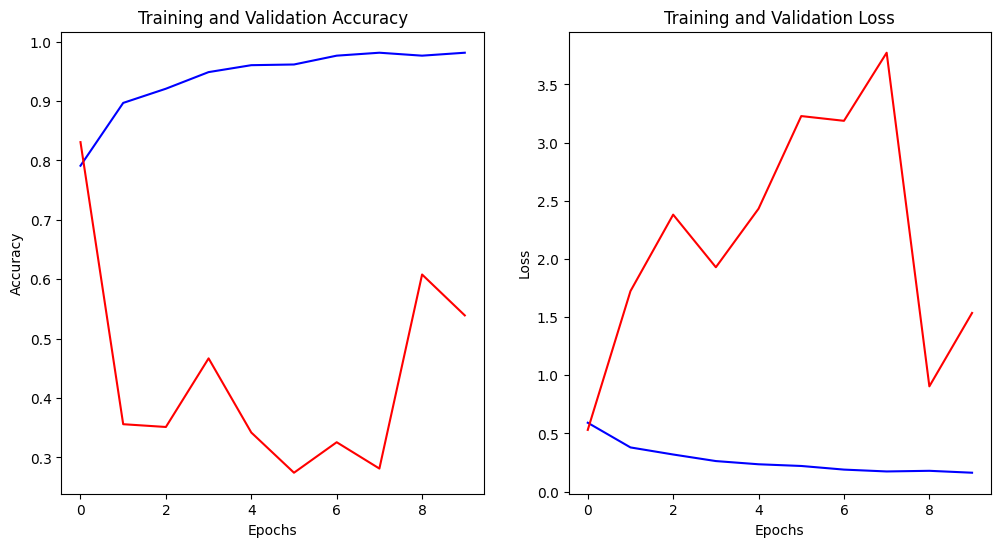

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(12,6))
plt.subplot(121), plt.plot(epochs, accuracy, 'b', label='Training Accuracy'), 
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(122), plt.plot(epochs, loss, 'b', label='Training Loss'), 
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Evaluation of the Model
This section includes everything about the evaluation of the model. The predicted results on the test datasets and the overall evaluation and thoughts on the model.

In [19]:
# Evaluate how well the model does in the test datasets
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.58566
Test Accuracy: 85.18%


In [20]:
CNN_test_loss, CNN_results = model.evaluate(test_images)
print(f"Test accuracy: {CNN_test_loss:.4f}")
print(f"Test accuracy: {CNN_results:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7460 - loss: 0.8981
Test accuracy: 0.5857
Test accuracy: 0.8518


In [21]:
test_images.reset() # Reset Generator

# Predict image
prediction = model.predict(test_images)
# As only one value, set round it off. 
prediction = np.round(prediction).astype(int)

CNN_labels = test_images.classes # True labels
target_names = list(test_images.class_indices.keys())
CNN_report = classification_report(CNN_labels, prediction, target_names=target_names, digits=4)
print("Classification Report:\n", CNN_report)

#labels = (train_images.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#prediction = [labels[conf_score[0]] for conf_score in prediction]

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
Classification Report:
               precision    recall  f1-score   support

     Healthy     0.8680    0.7951    0.8299       488
      Rotten     0.8403    0.8991    0.8687       585

    accuracy                         0.8518      1073
   macro avg     0.8541    0.8471    0.8493      1073
weighted avg     0.8529    0.8518    0.8511      1073



In [17]:
%store CNN_training_loss
%store CNN_training_acc

Stored 'CNN_training_loss' (list)
Stored 'CNN_training_acc' (list)


In [22]:
%store CNN_report
%store CNN_results

Stored 'CNN_report' (str)
Stored 'CNN_results' (float)


Confusion Matrix:
 [[388 100]
 [ 59 526]]


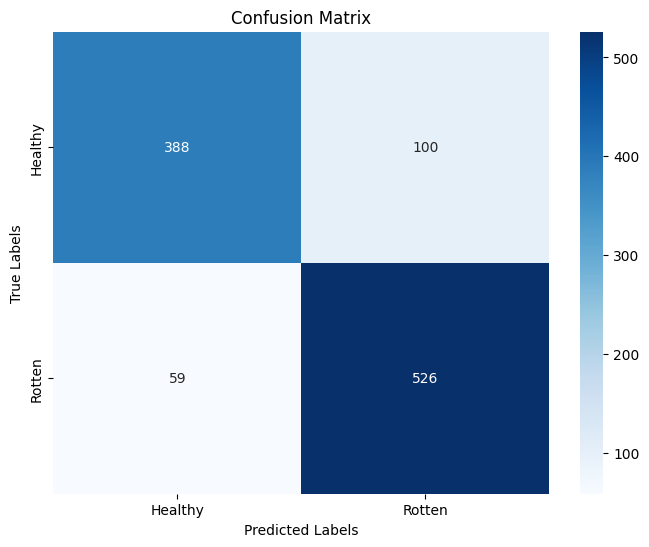

In [23]:
CNN_conf_matrix = confusion_matrix(CNN_labels, prediction)
print("Confusion Matrix:\n", CNN_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(CNN_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

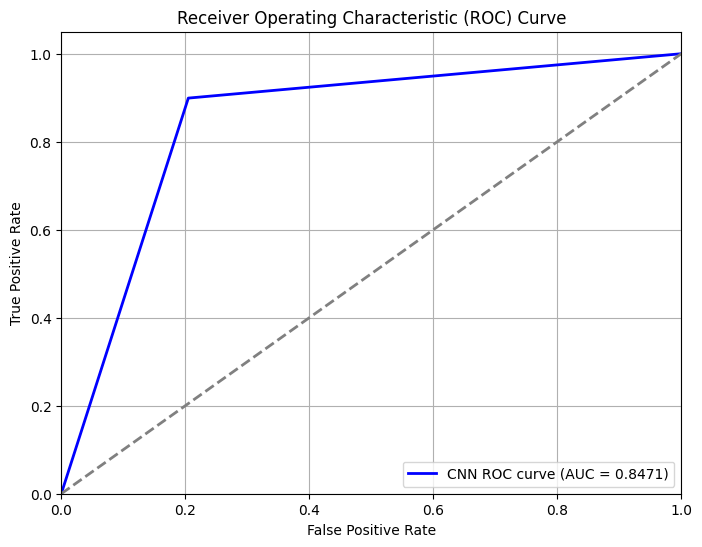

In [24]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(CNN_labels, prediction)
CNN_auc_score = roc_auc_score(CNN_labels, prediction)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN ROC curve (AUC = {CNN_auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [25]:
%store CNN_auc_score

Stored 'CNN_auc_score' (float64)


['Healthy']


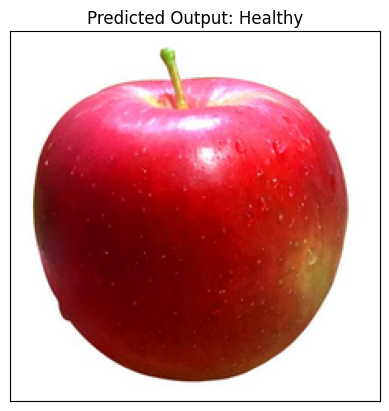

In [26]:
from PIL import Image

# Predicting with a random image fetched online
with Image.open("./FreshAppleTest.jpg") as img:
	img = img.resize((224,224), Image.LANCZOS)

	# Convert RGBA to RGB if necessary
	if img.mode == 'RGBA':
		img = img.convert('RGB')

	# Convert to Tensors
	tensor_img = tf.convert_to_tensor(img, dtype=tf.float32)
	# Add one more dimension to fit input shape
	tensor_img = tensor_img[None, :]

	# Same algorithm
	prediction = model(tensor_img)
	prediction = np.argmax(prediction,axis=1)

	labels = (train_images.class_indices)
	labels = dict((v,k) for k,v in labels.items())
	prediction = [labels[k] for k in prediction]
	# Show Prediction
	print(prediction)
	plt.imshow(img), plt.xticks([]),plt.yticks([]),plt.title(f"Predicted Output: {prediction[0]}")
	plt.show()

### Results and Discussion
Overall, it's good at discerning between rotten and healthy apples. With at 86% precision in detecting healthy apples, and a 84% in detecting rotten apples, it is able to differentiate between a rotten and a healthy apple pretty well.

The only thing that can be improved with this model is the Validation Loss and Accuracy. It could be hypothesized that it's caused by the lower amount of images for validation purposes, but could also be the model is not as good as other methods.